# Introduction

🚨 TODO
popsat vsechny kroky
obsah

In [9]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


data_files = glob.glob("chess_ratings/*.csv")
all_dfs = [pd.read_csv(file, sep='|') for file in data_files]

/tmp/ipykernel_147401/1100452732.py:9: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  all_dfs = [pd.read_csv(file, sep='|') for file in data_files]


# Data analysis

## Chess ratings
The analysed dataset are the Chess ratings from the FIDE.

In [2]:
example_df = all_dfs[5].iloc[:5]
example_df

,ID Number,Name,Fed,Sex,Tit,WTit,OTit,FOA,Rat,Gms,K,B-day,Flag,Year,Mon
0,35077023,A Chakravarthy,IND,M,NaN,NaN,NaN,NaN,1151,0,40,1986,i,2018,12
1,10207538,"A E M, Doshtagir",BAN,M,NaN,NaN,NaN,NaN,1840,0,40,1974,i,2018,12
2,5716365,"A Hamid, Harman",MAS,M,NaN,NaN,NI,NaN,1325,0,40,1970,NaN,2018,12
3,10206612,"A K M, Sourab",BAN,M,NaN,NaN,NaN,NaN,1708,0,40,0,i,2018,12
4,5045886,"A K, Kalshyan",IND,M,NaN,NaN,NaN,NaN,1826,0,20,1964,NaN,2018,12


The dataset contains data of chess players registered in FIDE (The International Chess Federation). One example represents data of games and ratings of a player. The data is aggregated by months, and it ranges from December 2017 to December 2019. Both male and female players are represented, there are separate titles for women, but some female players compete in the original categories (mixed gender) as well.

There are over 350k unique players.

In [36]:
data = pd.concat(all_dfs)
data["Year / month"] = [f"{y} / {m if (len(str(m)) == 2) else ('0' + str(m))}" for y, m in zip(data["Year"], data["Mon"])]
print("Players: " + str(len(data['ID Number'].unique())))

Players: 354525


## Column meanings

Column | Description
--- | ---
'ID Number', 'Name' | ID, name of the player
'Fed', 'Sex', 'B-day' | Country, gender and birth year
'Tit', 'WTit' | Title and female title
'OTit' | Other titles, e.g. Arbiter, Trainer...
'FOA' | FIDE online arena rating
'Rat' | Rating of the player
'Gms' | Number of games played in the month
'K' | development coefficient
'Flag' | (in)activity flag
'Year', 'Mon' | Month and year of the entry


---------------
source: https://ratings.fide.com/download_lists.phtml

K factor: https://en.wikipedia.org/wiki/Elo_rating_system#:~:text=United%20States%20Chess%20Federation%20ratings,-The%20United%20States&text=The%20K-factor,%20in%20the,in%20a%20tournament%20(m).

## Player data and demographics

### Countries
There are players from 192 different countries registered. Czechia is the 10th in player count, and Russia has the most chess players overall. More information about countries is in the first report.

### Player age
The most active players are children and young adults. With age, the interest in chess declines, with a slight increase close to retirement. Elderly people have a decline in active counts probably due to their worse health and lower population count.

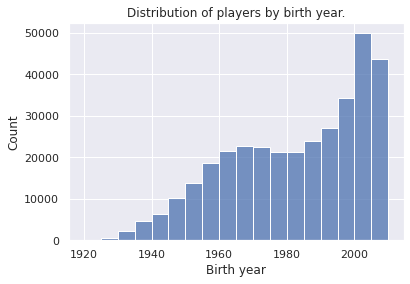

In [10]:
age_ppl = data[['ID Number', 'B-day']].drop_duplicates().reset_index()

plt.title("Distribution of players by birth year.")
sns.histplot(data=age_ppl[age_ppl['B-day'] > 1900], x='B-day', binrange=[1920, 2010], binwidth=5)
plt.xlabel("Birth year")
plt.show()

### Activity

Activity flag is different for women and men competitions. The value nan means "active man", which is bad practice, we will create a new boolean column indicating activity regardless of gender.

In [13]:
data.Flag.unique()

array(['i', nan, 'wi', 'w'], dtype=object)

In [40]:
print(data[data.Flag == 'wi'].Sex.unique())
print(data[data.Flag == 'i'].Sex.unique())

data.loc[data['Flag'] == 'wi', 'Flag'] = 'i'
data.loc[data['Flag'] == 'w', 'Flag'] = ''

['F']
['M']


There is much less women chess players than men chess players.

The distribution of active month counts is mostly uniform, with larger number of players active for 1 year, and a lot of players were active the whole time.

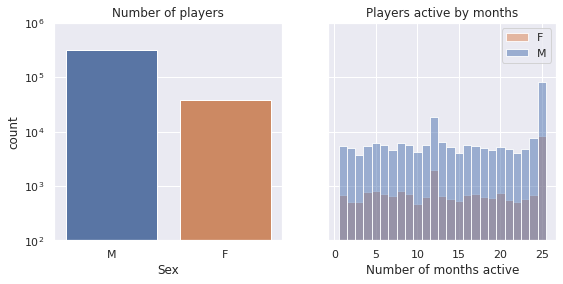

In [18]:
n_years = data[data['Flag'] != 'i'][['ID Number', 'Sex', 'Year']].groupby(['ID Number', 'Sex']).count()

fig, axs = plt.subplots(ncols=2, figsize=(9,4), sharey=True)

sns.countplot(data=data[["ID Number", "Sex"]].drop_duplicates(["ID Number", "Sex"]), x="Sex", ax=axs[0])
plt.ylim(10**2, 10**6)
axs[0].set_xlabel("Sex")
axs[0].set_title("Number of players")
plt.yscale('log')

sns.histplot(data=n_years, x='Year', hue='Sex', discrete=True, log_scale=(False, True), ax=axs[1])
axs[1].legend(["F", "M"], loc='upper right')
plt.ylim(10**2, 10**6)
axs[1].set_xlabel("Number of months active")
axs[1].set_title("Players active by months")
plt.show()

The overall number of registered players increased during the time interval, however number of active players increased at a slower pace.

In [41]:
data['active'] = (data['Flag'] != 'i').astype(int)

In [27]:
inactive_counts = data[["Year", "Mon", "active"]].groupby(["Year", "Mon"]).sum()
inactive_counts = inactive_counts.reset_index()
inactive_counts["Year / month"] = [f"{y} / {m if (len(str(m)) == 2) else ('0' + str(m))}" for y, m in zip(inactive_counts["Year"], inactive_counts["Mon"])]

In [29]:
all_counts = data[["Year", "Mon", "ID Number"]].groupby(["Year", "Mon"]).count()
all_counts = all_counts.reset_index()
all_counts["Year / month"] = [f"{y} / {m if (len(str(m)) == 2) else ('0' + str(m))}" for y, m in zip(all_counts["Year"], all_counts["Mon"])]

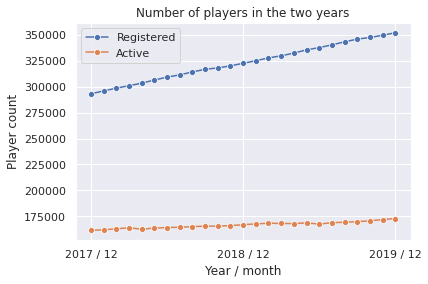

In [30]:
sns.lineplot(data=all_counts, x="Year / month", y="ID Number", marker='o', label='Registered')
sns.lineplot(data=inactive_counts, x="Year / month", y="active", marker='o', label='Active')

plt.xticks(["2017 / 12", "2018 / 12", "2019 / 12"])
plt.title("Number of players in the two years")
plt.ylabel("Player count")
plt.show()

### Titles and ratings

FIDE arena titles are divers:

In [28]:
data.FOA.unique()

array([nan, 'ACM', 'AIM', 'AFM', 'AGM', 'FI,FA,IA,FT,IO,SIAGM', 'SI,SI',
       'IA', 'FST', 'IO', 'FI    AIM', 'IO,FT', 'FT', 'SI', 'IA    AGM',
       ',IO', 'IA,SI', 'FI', 'DI'], dtype=object)

For simplicity, we will focus on the main rating classes. The titles of FIDE are the following:

- CM - Candidate Master
- FM - FIDE Master
- IM - International Master
- GM - Grand Master

Women titles have a prefix of "W". The titles are achieved by 11 % of women and only 5 % of men.

More data about the titles can be found in the previous report.

The rating distributions match the prestige of a title, with better titles awarded to higher ranking players. In the male division, the rating distributions are more narrow than in the female section. The FIDE master title is occassionally achieved by some players with a low rating, while the better titles are awarded mostly to players with a very high rating

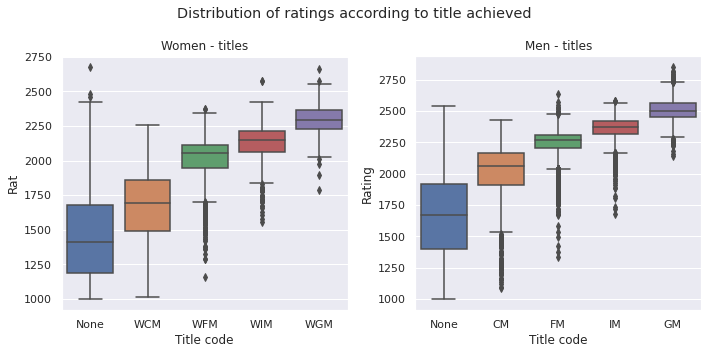

In [31]:
data["WTit_filled"] = data["WTit"].fillna('None')
data["Tit_filled"] = data["Tit"].fillna('None')


def group_rating(d, title):
    name = f"{title}_filled"
    d[name] = d[title].fillna("None")
    
    return d[["ID Number", "Rat", name]].groupby(["ID Number", name]).mean().reset_index()

fig, axs = plt.subplots(ncols=2, figsize=(10,5))
sns.boxplot(data=group_rating(data[data["Sex"] == "F"].copy(), "WTit"), x='WTit_filled', y="Rat",
            order=["None", "WCM", "WFM", "WIM", "WGM"], ax=axs[0])
plt.ylabel("Rating")

sns.boxplot(data=group_rating(data[data["Sex"] == "M"].copy(), "Tit"), x='Tit_filled', y="Rat",
            order=["None", "CM", "FM", "IM", "GM"], ax=axs[1])

axs[0].set_title("Women - titles")
axs[1].set_title("Men - titles")

plt.suptitle("Distribution of ratings according to title achieved")
plt.ylabel("Rating")
axs[0].set_xlabel("Title code")
axs[1].set_xlabel("Title code")
plt.tight_layout()
plt.show()

Finally, we analyzed the score of players that were active in the whole period of 2 years. Specifically, we analyzed how much the score from 12/2019 improved compared to 12/2017. We plot the difference between the two scores.

In the male section, half of the players got better and the other half got worse. For most players, the score difference was not that large, however there were some outliers with a very large improvement. In the female category, slightly more than a half improved, and the score differences were for most players quite noticeable.

Number of players active the whole time:  89077


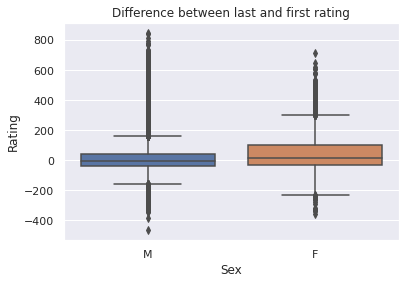

In [42]:
active_ppl = data[data["active"] == 1][["ID Number", "Mon"]].groupby("ID Number").count()

all_timers = active_ppl[active_ppl["Mon"] == 25]
all_timers = data[data["ID Number"].isin(all_timers.index)].reset_index()
print("Number of players active the whole time: ", len(all_timers["ID Number"].unique()))

first_month = all_timers[all_timers["Year / month"] == "2017 / 12"].set_index("ID Number")
last_month = all_timers[all_timers["Year / month"] == "2019 / 12"].set_index("ID Number")

rating_diff = last_month["Rat"] - first_month["Rat"]
rating_diff = rating_diff.to_frame()
rating_diff["Sex"] = first_month["Sex"]

plt.title("Difference between last and first rating")
sns.boxplot(data=rating_diff, x="Sex", y="Rat")
plt.ylabel("Rating")
plt.show()

# Preprocessing

There are some changes, errors or inconsistencies in the data.

1. some players (2549) changed their name - some due to typos or name change after marriage
2. some players changed their gender - apart from errors, this could mean they are trans
3. some changed their birth year
4. some players changed their country

In the modeling, we won't use player names and their countries, as names are not relevant features and countries would lead
to a large feature space. As so, problems **1. and 4. don't need to be solved**.

### Gender changes

In [55]:
dupl_gender = data[['ID Number', 'Sex', 'Flag']].groupby(['ID Number', 'Sex']).count().reset_index()
dupl_gender = dupl_gender[dupl_gender.duplicated('ID Number')]
print(f"Number of gender changes: {len(dupl_gender)}")

Number of gender changes: 363


Since the number of people who changed gender is relatively small, we will drop them. 

### Wrong years
If the birth year is 0 and was changed later on, we try to fill it with the correct value. Otherwise we **drop all rows** with people **younger than 5 years** or **older than 110 years**.

## Basic preprocessing - summary
- we drop people with changing gender
- we drop or fill invalid birth years
- we unify the activity flag column to be gender-independent
- we convert both mixed and female titles to numerical representation
    - ordered by importance (see distribution of ratings by title plot)
    - from worst to best - `["None", "CM", "FM", "IM", "GM"]`

All steps are done in the function `preprocess_data`

In [74]:
from spark_utils import preprocess_data

data = pd.concat(all_dfs)
data = preprocess_data(data)

In [77]:
print("Titles converted to numerical values:")
print(data['tit'].unique())
print(data['wtit'].unique())

Titles converted to numerical values:
[0 3 4 2 1]
[0 2 3 1 4]


## SPARK preprocessing
`pyspark` was used mainly to aggregate the data. As described in the introduction, for every player we want to predict if their rating changed. This means that we need data in the format `user, y`, but raw data contains multiple rows per user.



# Modeling

# Evaluation